Pytraction base
===============
In this section mechanics for `Base` class will be explained. The `Base` class is parent to all pytraction classes. It supports functionality related to modeling, type checking and serialization. The `Base` is build on python `dataclasses.dataclass`. Therefore it
has similar way of declaration of its attributes. All public attributes has to be json compatible and has to be annotated
Json compatible types are: 
* elementary types:
   str, int, bool and float.
Example of subclass with elementary types:

In [3]:
from pytraction.base import Base

class Foo(Base):
    a: str
    b: int
    c: bool
    d: float

Foo(a="a", b=0, c=False, d=0.1)



Foo(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, a='a', b=0, c=False, d=0.1)

Dictionaries and lists are also supported but not as standard python list and dict but specialized versions of them to ensure all items/key-values are also json compatible. Let's try to define class with list attribute of type list (standard python list)

In [4]:
class Foo2(Base):
    a: list

JSONIncompatibleError: Attribute a is not json compatible <class 'list'>

To fix that, typed list has to be used instead. TList class ensures all items in the list are of the specified type (class or subclass)

In [5]:
from pytraction.base import TList
class Foo3(Base):
    l: TList[int]

Foo3(l=TList[int]([1,2,3]))

Foo3(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, l=TList[int,](_CUSTOM_TYPE_TO_JSON=False, _orig_cls=TList, _list=[1, 2, 3]))

Last supported attribute type in Base subclasses are other Base derived subclasses. Following example use `Foo` class defined before

In [6]:
class Foo4(Base):
    foo: Foo

Foo4(foo=Foo(a='a', b=0, c=False, d=0.1))

Foo4(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, foo=Foo(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, a='a', b=0, c=False, d=0.1))

If you have use case where multiple types are needed to be supported for specific attribute, you set attribute to support multiple types with typing Union

In [7]:
from typing import Union
class Foo11(Base):
    a: Union[int, str]

Foo11(a='a')
Foo11(a=10)

Foo11(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, a=10)

Union is set to integer and string, if we try to set there None, it will fail

In [8]:
Foo11(a=None)

TypeError: Cannot set attribute Foo11.a to None(<class 'NoneType'>), expected typing.Union[int, str]

All types must be respected. You cannot set attribute to incorrect type

In [9]:
Foo3(l='a')

TypeError: Cannot set attribute Foo3.l to a(<class 'str'>), expected TList[int]

As mentioned, also inner types of containers needs to have the right type:

In [10]:
Foo3(l=TList[str](['a', 'b', 'c']))

TypeError: Cannot set attribute Foo3.l to TList[str,](_CUSTOM_TYPE_TO_JSON=False, _orig_cls=TList, _list=['a', 'b', 'c'])(TList[str]), expected TList[int]

Serialization
=============

With all mentioned above we can expect everything public in the class is json compatible. Therefore whole class can be converted to a json

In [11]:
Foo(a="a", b=0, c=False, d=0.1).to_json()


{'$type': {'type': 'Foo', 'args': [], 'module': '__main__'},
 '$data': {'a': 'a', 'b': 0, 'c': False, 'd': 0.1}}

Dumped dictionary contains json representation of the class instance. '$type' attribute indicates type of the class which was dumped with generic args and module containing the class.
With that it can be deserialized by loading the json by the Base class

In [12]:
foo = Foo(a="a", b=0, c=False, d=0.1)
serialized = foo.to_json()
foo_copy = Base.from_json(serialized)
assert foo == foo_copy

More complex example including object attributes

In [13]:
import json
class Foo5(Base):
    some_int: int

class Foo6(Base):
    a: str
    l: TList[int]
    foo5: Foo5

f6 = Foo6(a='a', l=TList[int]([1,2,3]), foo5=Foo5(some_int=10))
serialized = f6.to_json()
print(json.dumps(serialized, indent=5))
f6_copy = Base.from_json(serialized)
#print(json.dumps(f6_copy.to_json(), indent=5))
assert f6 == f6_copy


{
     "$type": {
          "type": "Foo6",
          "args": [],
          "module": "__main__"
     },
     "$data": {
          "a": "a",
          "l": {
               "$type": {
                    "type": "TList",
                    "args": [
                         {
                              "type": "int",
                              "args": [],
                              "module": "builtins"
                         }
                    ],
                    "module": "pytraction.base"
               },
               "$data": [
                    1,
                    2,
                    3
               ]
          },
          "foo5": {
               "$type": {
                    "type": "Foo5",
                    "args": [],
                    "module": "__main__"
               },
               "$data": {
                    "some_int": 10
               }
          }
     }
}


Not everytime we need to know information about class type in serialized output. So it's possible to use `content_to_json` method

In [14]:
f6.content_to_json()

{'a': 'a', 'l': [1, 2, 3], 'foo5': {'some_int': 10}}

Even dump like that can be deserialized, but you need to use original class for it, not just Base class

In [15]:
fdump = f6.content_to_json()
f6_copy2 = Foo6.content_from_json(fdump)
assert f6_copy2 == f6
print("equal")

equal


Note that when using `content_from_json` it's important to keep in mind that deserialization is based on class attributes only as from the input there's no information of it. For example you define class called for example `Core` and then subclasses `Implementation1(Core)` and `Implementation2(Core)`. In other classes you want to use content_from_json to deserialization. However you cannot set attribute `imp` to type `Core` as deserialization would set `imp` to be instance of class `Core`. You also cannot use `Union[Implementation1, Implementation2]` if `Implementation1` has very same attributes as `Implementation2`. In that case data would be always deserialized as `Implementation2`

In [16]:
from pytraction.base import Base
from typing import Union

class Core(Base):
    x: int

class Implementation1(Core):
    x: int

class Implementation2(Core):
    x: int

class ImplementationUser(Base):
    imp: Union[Implementation1, Implementation2]

iu_json = ImplementationUser(imp=Implementation1(x=10)).content_to_json()
iu_json2 = ImplementationUser(imp=Implementation2(x=10)).content_to_json()

ui1 = ImplementationUser.content_from_json(iu_json)
ui2 = ImplementationUser.content_from_json(iu_json2)

print(ui1.imp)
print(ui2.imp)

Implementation2(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, x=10)
Implementation2(_CUSTOM_TYPE_TO_JSON=False, _orig_cls=None, x=10)


Tractions basics
================

Traction is Base subclass which represents one logical block. Idea of traction block is to generate, prepare or process data and send them to output. Specialized method how to fetch data or store data from external resources shouldn't be part of traction itself but rather defined as a resource.

It takes 3 different types of inputs:
1. inputs - provided by user or from output of another traction block
2. arguments - user provided constant arguments which can affect behavior of the traction run - like timeout, retries, threshold and so on
3. resources - Resource represents a block which allows external functionality within the traction run code. It can be for example file storage, database client, API client for any external service. Resource is ment to provide basic functionality, like fetching, storing or modifying resources, any complex manipulation with the data shouldn't be handled by traction

Example of traction can be seen bellow


In [17]:
from pytraction.base import Traction, In, Out, Res, Arg, OnUpdateCallable

class TestTraction(Traction):
    i_in: In[int]
    o_out: Out[int]
    a_multiplier: Arg[int]

    # yes, it's run with underscore
    def _run(self, on_update: OnUpdateCallable = None):
        #out  = self.r_et_client.r.get_advisory_metadata(...)
        self.o_out.data = self.i_in.data * self.a_multiplier.a
        

There are few rules to make code cleaner which must be applied when writing Traction subclass. Every input must start with prefix i_, every output with o_, every resource with r_ and very argument with a_. Any other attributes are not allowed to be defined. See bellow:

In [18]:
class WrongTraction(Traction):
    custom_attr: int

TypeError: Attribute custom_attr has start with i_, o_, a_, r_ or d_

In [19]:
class WrongTraction(Traction):
    i_in1: Out[int]

TypeError: Attribute i_in1 has to be type In[ANY], but is Out[int]

Only other attributes allowed to be in Traction subclass are documentation attributes starting with d_ and type string.

In [20]:
class TestTraction(Traction):
    i_in: In[int]
    o_out: Out[int]
    a_multiplier: Arg[int]
    d_: str = "This is test traction for demonstrating pytraction capabilities"
    d_i_in: str = "Integer input"
    d_a_multiplier: str = "Integer Multiplier"
    d_o_out: str = "Integer output calculated like i_in * a_multiplier"

    def _run(self, on_update: OnUpdateCallable = None):
        self.o_out.data = self.i_in.data * self.a_multiplier.a

Now lets initialize the traction and see how it looks

In [21]:
tt = TestTraction(uid='test-traction', i_in=In[int](data=10), a_multiplier=Arg[int](a=2))
print(json.dumps(tt.content_to_json(), indent=4))

{
    "uid": "test-traction",
    "state": "ready",
    "skip": false,
    "skip_reason": "",
    "errors": [],
    "stats": {
        "started": "",
        "finished": "",
        "skipped": false
    },
    "details": {},
    "i_in": {
        "data": 10
    },
    "o_out": {
        "data": 0
    },
    "a_multiplier": {
        "a": 2
    },
    "d_": "This is test traction for demonstrating pytraction capabilities",
    "d_i_in": "Integer input",
    "d_a_multiplier": "Integer Multiplier",
    "d_o_out": "Integer output calculated like i_in * a_multiplier"
}


You can see traction provides also some additional usefull attributes like state, skip, stats. Errors and details are user controlled string list where you can put anything usefull about traction run progress.
Now lets run the traction

In [22]:
tt.run()
print(json.dumps(tt.content_to_json(), indent=4))

{
    "uid": "test-traction",
    "state": "finished",
    "skip": false,
    "skip_reason": "",
    "errors": [],
    "stats": {
        "started": "2024-05-02T12:32:02.796522",
        "finished": "2024-05-02T12:32:02.797026",
        "skipped": false
    },
    "details": {},
    "i_in": {
        "data": 10
    },
    "o_out": {
        "data": 20
    },
    "a_multiplier": {
        "a": 2
    },
    "d_": "This is test traction for demonstrating pytraction capabilities",
    "d_i_in": "Integer input",
    "d_a_multiplier": "Integer Multiplier",
    "d_o_out": "Integer output calculated like i_in * a_multiplier"
}


Now lets create another traction and connect it to output of already defined one

In [23]:
class TestTraction2(Traction):
    i_in: In[int]
    o_out: Out[int]
    a_divider: Arg[int]
    d_: str = "This is test traction for demonstrating pytraction capabilities"
    d_i_in: str = "Integer input"
    d_a_divider: str = "Integer divider"
    d_o_out: str = "Integer output calculated like i_in / a_divider"

    def _run(self, on_update: OnUpdateCallable = None):
        self.o_out.data = self.i_in.data / self.a_divider.a

tt1 = TestTraction(uid='test-traction', i_in=In[int](data=10), a_multiplier=Arg[int](a=2))
tt2 = TestTraction2(uid='test-traction2', i_in=tt1.o_out, a_divider=Arg[int](a=4))

tt1.run()
tt2.run()
print(json.dumps(tt2.content_to_json(), indent=4))

{
    "uid": "test-traction2",
    "state": "finished",
    "skip": false,
    "skip_reason": "",
    "errors": [],
    "stats": {
        "started": "2024-05-02T12:32:03.469520",
        "finished": "2024-05-02T12:32:03.469955",
        "skipped": false
    },
    "details": {},
    "i_in": {
        "data": 20
    },
    "o_out": {
        "data": 5.0
    },
    "a_divider": {
        "a": 4
    },
    "d_": "This is test traction for demonstrating pytraction capabilities",
    "d_i_in": "Integer input",
    "d_a_divider": "Integer divider",
    "d_o_out": "Integer output calculated like i_in / a_divider"
}


In the example above you can see i_in (In[int]) attribute of TestTraction2 is set to o_out(Out[int]) of TestTraction. It's possible because Out class is subclass of In class. This way you can connect an input attribute to an output attribute

Tractors
========

In the example above you can see how two tractions can be connected togeher. However it's not very practical. Image you would have to wrap to code into some method and call it every time you need to prepare tractions for run. Also it's not very reusable. Therefore there's special Traction subclass called Tractor which basically allows to connect two or more tractions together and execute them in order in which they are defined


In [24]:
from pytraction.base import TIn, In, Arg, Traction
from pytraction.tractor import Tractor

class TestTractor(Tractor):
    i_in: In[int] = TIn[int]() # If you don't want to initialize input with some dummy value you can use TIn
    a_divider: Arg[int] = Arg[int](a=3432432) # Some default can be defined here
    a_multiplier: Arg[int] = Arg[int](a=54356)

    # Do you feel little heresy when doing code excution in the class definition?
    t_t1: TestTraction = TestTraction(uid='test-traction-1', i_in=i_in, a_multiplier=a_multiplier)
    t_t2: TestTraction2 = TestTraction2(uid='test-traction-2', i_in=t_t1.o_out, a_divider=a_divider)

    o_out: Out[int] = t_t2.o_out

One thing you can notice is that Tractor class allows new attributes of type Traction which needs to start with t_ prefix and they have to be Traction subclasses.
Another thing is, here you can probably start arguing that it cannot work as everything is defined on the class level so when class is instantiated several times it will overwrite same class attributes in every instance run. But everything defined above is serving just to define connections between attributes. When tractor is initiated all tractions are copied and provided with real data

In [25]:
tt = TestTractor(uid='test-tractor-1', i_in=In[int](data=10), a_divider=Arg[int](a=4), a_multiplier=Arg[int](a=2))
tt.run()
print(json.dumps(tt.content_to_json(), indent=4))

{
    "uid": "test-tractor-1",
    "state": "finished",
    "skip": false,
    "skip_reason": "",
    "errors": [],
    "stats": {
        "started": "2024-05-02T12:32:05.205561",
        "finished": "2024-05-02T12:32:05.207559",
        "skipped": false
    },
    "details": {},
    "tractions": {
        "t_t1": {
            "uid": "test-tractor-1::test-traction-1",
            "state": "finished",
            "skip": false,
            "skip_reason": "",
            "errors": [],
            "stats": {
                "started": "2024-05-02T12:32:05.206104",
                "finished": "2024-05-02T12:32:05.206552",
                "skipped": false
            },
            "details": {},
            "i_in": {
                "data": 10
            },
            "o_out": {
                "data": 20
            },
            "a_multiplier": {
                "a": 2
            },
            "d_": "This is test traction for demonstrating pytraction capabilities",
            "d_i

Other specialized tractions
===========================
Lets assume we have a traction which runs checksum calculation on input string data

In [26]:
import hashlib
class CSumCalc(Base):
    def sha256sum(self, data):
        return hashlib.sha256(data.encode('utf-8')).hexdigest()

class TChecksum(Traction):
    i_data: In[str]
    o_csum: Out[str]
    r_csum_calc: Res[CSumCalc]

    def _run(self, on_update: OnUpdateCallable = None):
        self.o_csum.data = self.r_csum_calc.r.sha256sum(self.i_data.data)

csc = CSumCalc()
tcs = TChecksum(uid='sum-calc-1',
                i_data=In[str](data='hello world!'),
                r_csum_calc=Res[CSumCalc](r=csc))
tcs.run()
tcs.o_csum.data

'7509e5bda0c762d2bac7f90d758b5b2263fa01ccbc542ab5e3df163be08e6ca9'

STMD
----

Now imagine you want to calculate checksum of more then one input. For this use case, there's no need to define new traction. But instead you can use special class called STMD (single traction, multiple data) which wraps original class and instead of original input expects list of inputs.

In [27]:
from typing import Type

from pytraction.base import STMD, TList, STMDExecutorType

class STMD_TChecksum(STMD):
    _traction: Type[Traction] = TChecksum
    
    i_data: In[TList[In[str]]]
    o_csum: Out[TList[Out[str]]]
    r_csum_calc: Res[CSumCalc]

inputs = TList[In[str]]([In[str](data='hello world!'), In[str](data='How are you?'), In[str](data='Are you ready for this?')])

stmd_tcs = STMD_TChecksum(
    uid='stmd-sum-calc-1', 
    i_data=In[TList[In[str]]](data=inputs),
    r_csum_calc=Res[CSumCalc](r=csc),
    a_pool_size=Arg[int](a=3)
)
stmd_tcs.run()
print(json.dumps(stmd_tcs.o_csum.content_to_json(), indent=4))

{
    "data": [
        {
            "data": "7509e5bda0c762d2bac7f90d758b5b2263fa01ccbc542ab5e3df163be08e6ca9"
        },
        {
            "data": "df287dfc1406ed2b692e1c2c783bb5cec97eac53151ee1d9810397aa0afa0d89"
        },
        {
            "data": "05913c34bf09a774f2e8e2b8ee6b5edc4d3762cdf7758692583cbe4c269d0406"
        }
    ]
}


By default it runs the traction in for loop in without any parallelism, but you can specify a_executor_type attribute to run traction in threads or in processes.

In [28]:
stmd_tcs = STMD_TChecksum(
    uid='stmd-sum-calc-1', 
    i_data=In[TList[In[str]]](data=inputs),
    r_csum_calc=Res[CSumCalc](r=csc),
    a_pool_size=Arg[int](a=3),
    a_executor_type=Arg[STMDExecutorType](a=STMDExecutorType.THREAD)
)
stmd_tcs.run()
print(json.dumps(stmd_tcs.o_csum.content_to_json(), indent=4))

{
    "data": [
        {
            "data": "7509e5bda0c762d2bac7f90d758b5b2263fa01ccbc542ab5e3df163be08e6ca9"
        },
        {
            "data": "df287dfc1406ed2b692e1c2c783bb5cec97eac53151ee1d9810397aa0afa0d89"
        },
        {
            "data": "05913c34bf09a774f2e8e2b8ee6b5edc4d3762cdf7758692583cbe4c269d0406"
        }
    ]
}


Multitractor
------------

Lets assume we have traction which ahve tractions defined like this:

Regular tractor class runs tractions in this order: t1, t2, t3, t4. But after t1 is started both t2 and t3 can start together as they depend only on inputs from t1. To do that, you can simply use **MultiTractor class** which splits tractions into waves based on input dependencies. For example above it should look like this:

Testing
=======

Lets create simple weather forecast rendering traction:

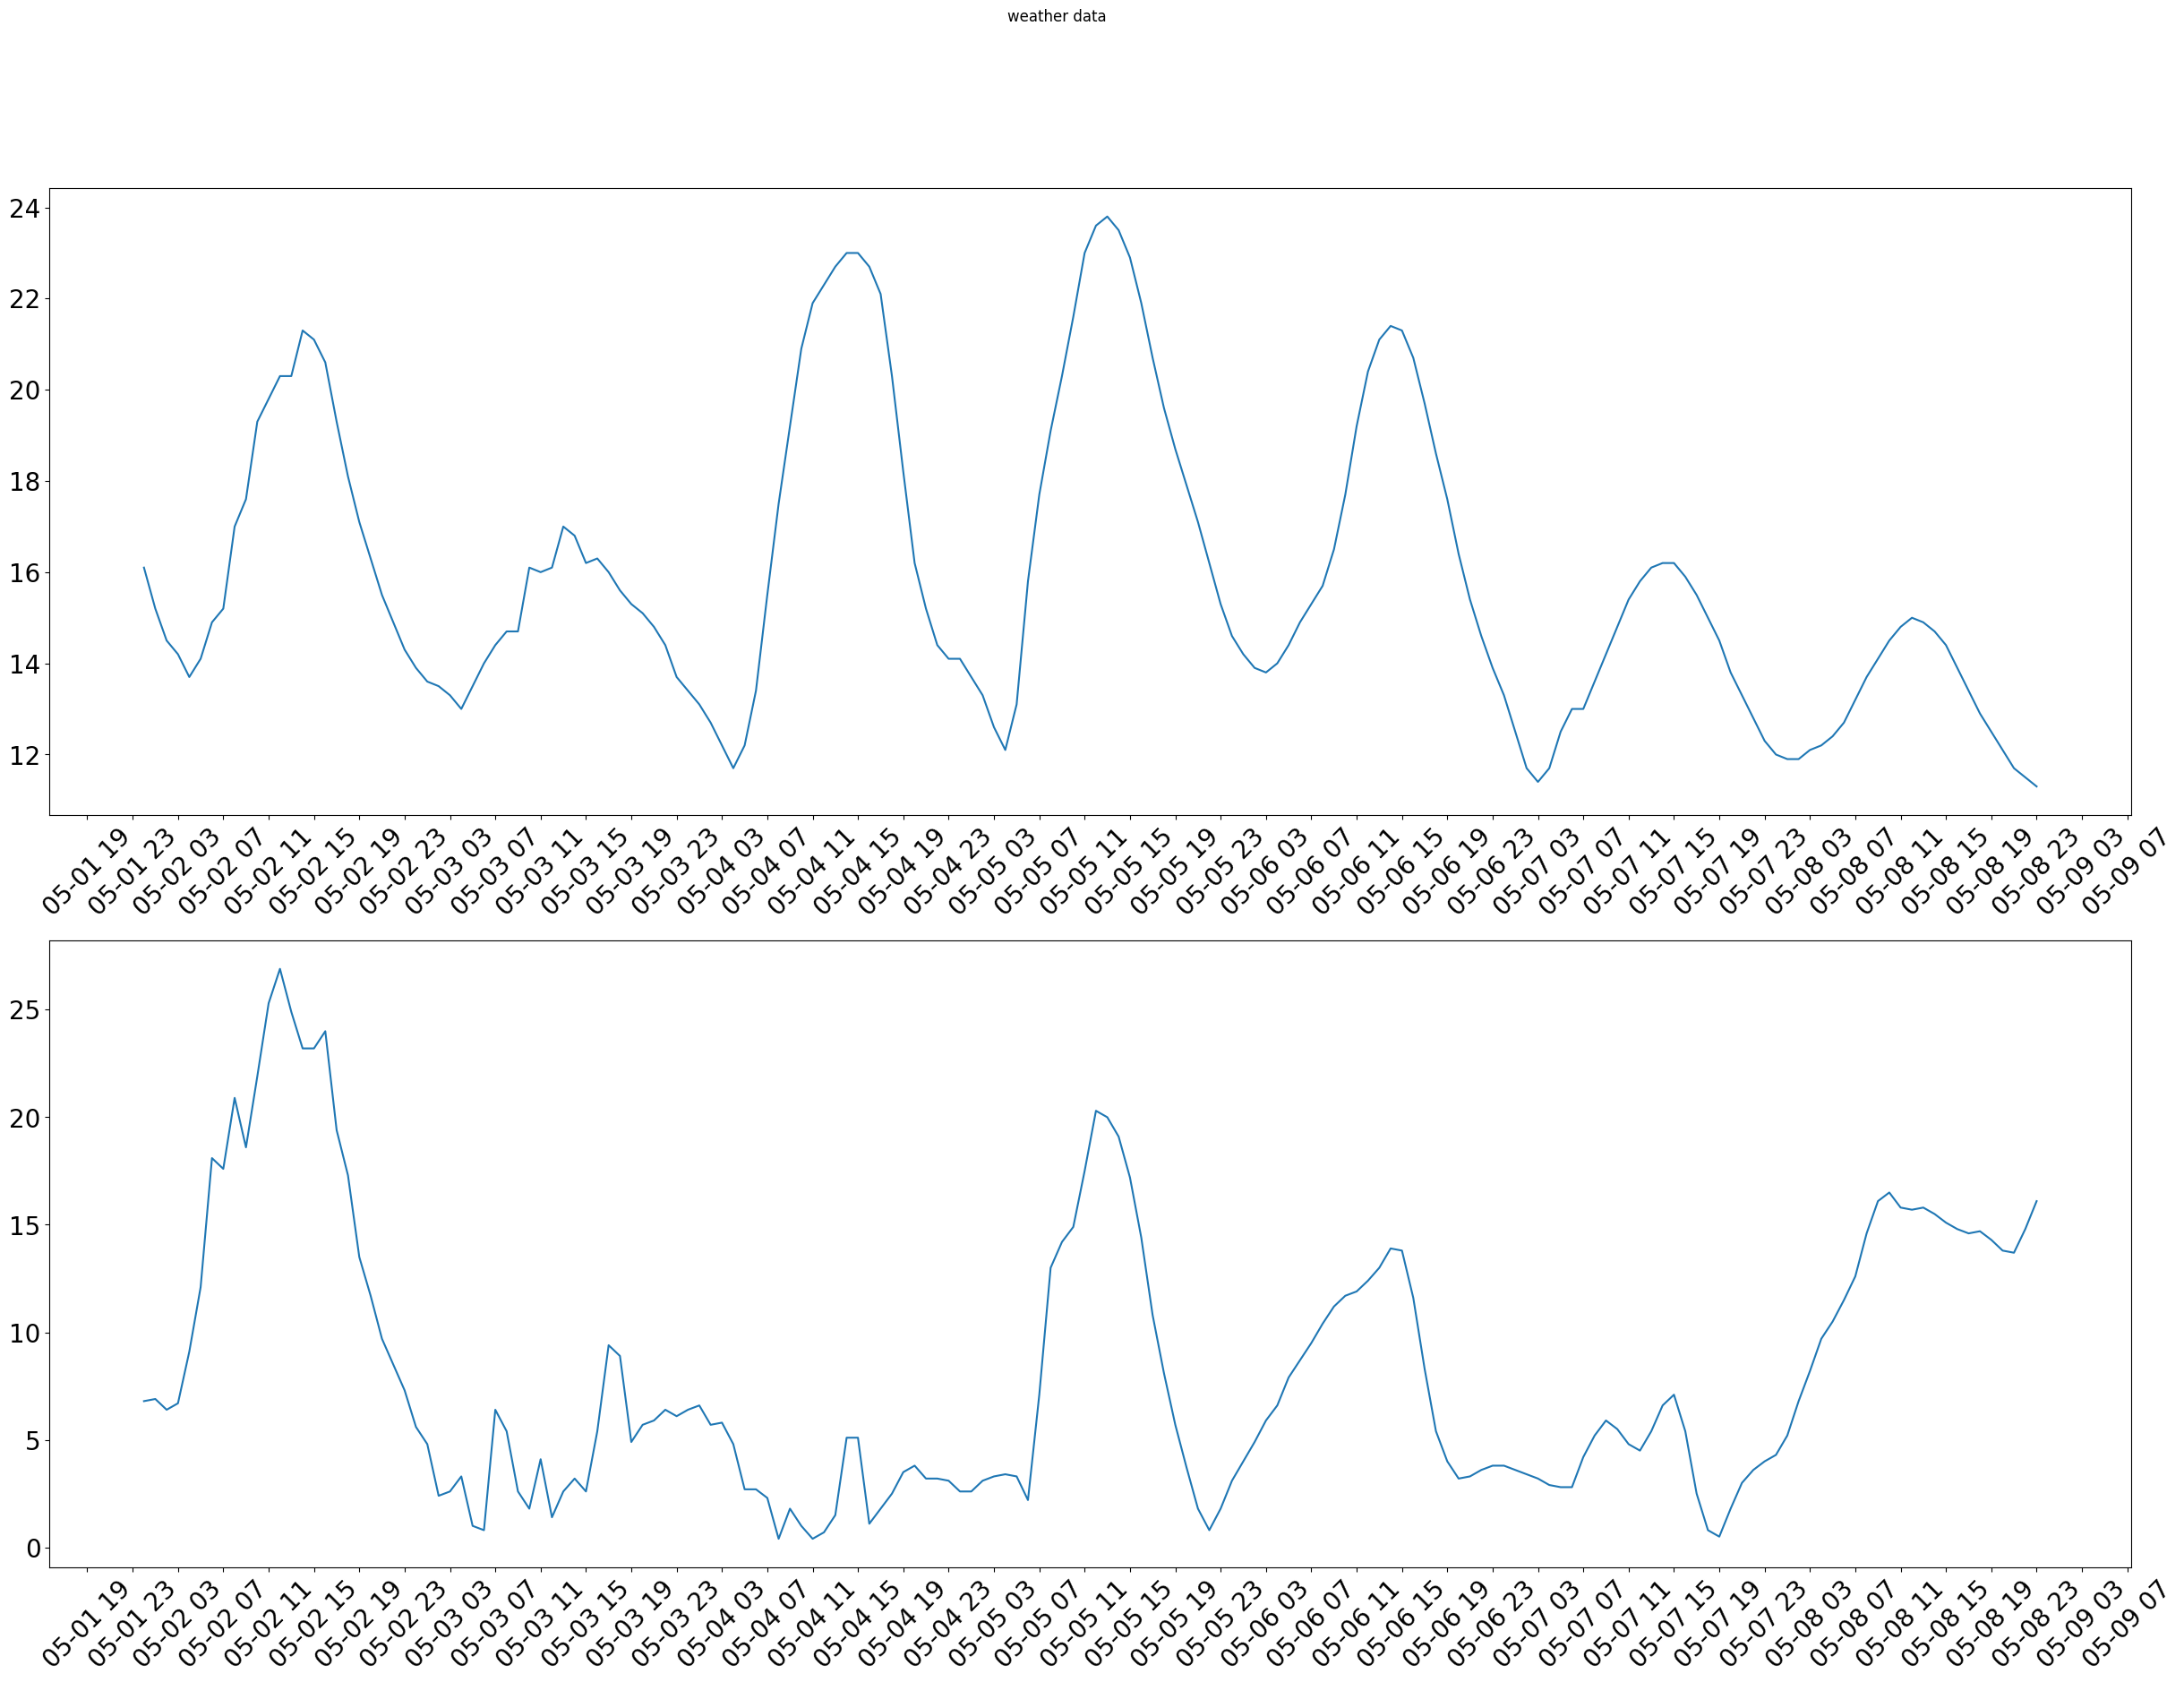

In [29]:
from pytraction.base import Base, In, Out, Res, Traction, TList, OnUpdateCallable
from typing import Union
import datetime

import requests
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator

class WeatherUnits(Base):
    time: str
    temperature_2m: str
    wind_speed_10m: str

class Forecast(Base):
    time: TList[str]
    temperature_2m: TList[float]
    relative_humidity_2m: TList[int]
    wind_speed_10m: TList[float]

class WeatherData(Base):
    latitude: float
    longitude: float
    generationtime_ms: float
    utc_offset_seconds: int
    timezone: str
    timezone_abbreviation: str
    elevation: float
    hourly_units: WeatherUnits
    hourly: Forecast

class WeatherForecast(Base):
    def get_weather_forecast(self, latitude: float, longitude: float):
        ret = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m")
        ret.raise_for_status()
        return WeatherData.content_from_json(ret.json())

class GenerateWeatherGraphData(Traction):
    i_longitude: In[float]
    i_latitude: In[float]
    r_weather_fc_client: Res[WeatherForecast]
    o_x_axis: Out[TList[Union[str, float, int]]]
    o_y_series: Out[TList[TList[Union[int, float]]]]

    def _run(self, on_update: OnUpdateCallable = None):
        res = self.r_weather_fc_client.r.get_weather_forecast(self.i_latitude.data, self.i_longitude.data)
        for time in res.hourly.time:
            self.o_x_axis.data.append(time)
        self.o_y_series.data.append(TList[float]([]))
        for temp in res.hourly.temperature_2m:
            self.o_y_series.data[0].append(temp)
        self.o_y_series.data.append(TList[float]([]))
        for wind in res.hourly.wind_speed_10m:
            self.o_y_series.data[1].append(wind)

class PlotGraphData(Traction):
    i_x_axis: In[TList[Union[str, float, int]]]
    i_y_series: In[TList[TList[Union[int, float]]]]

    def _run(self, on_update: OnUpdateCallable = None):
        time_axis = [datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M') for x in self.i_x_axis.data]
        fig, axs = plt.subplots(2, figsize=(30, 20))
        fig.suptitle('weather data')
        for n, yseries in enumerate(self.i_y_series.data):
            axs[n].plot(time_axis, yseries)
            axs[n].xaxis.set_major_locator(HourLocator(interval=4))
            axs[n].tick_params(axis='x', labelrotation=45, labelsize=20)
            axs[n].tick_params(axis='y', labelsize=20)
        plt.show()
        

wfc = WeatherForecast()
gwgd = GenerateWeatherGraphData(uid='brno-weather-data',
                                i_longitude=In[float](data=16.606836),
                                i_latitude=In[float](data=49.195061),
                                r_weather_fc_client=Res[WeatherForecast](r=wfc))
pgd = PlotGraphData(uid='plot-graph-data', i_x_axis=gwgd.o_x_axis, i_y_series=gwgd.o_y_series)
gwgd.run()
pgd.run()
print('')


Now we also want to write some tests for it. As all functionality is in resources we don't need to patch anything. It's just enough to write FakeWeatherForecast client

In [30]:
class FakeWeatherForecast(WeatherForecast):
    def get_weather_forecast(self, latitude: float, longitude: float):
        return WeatherData.content_from_json({
            "latitude": 49.2,
            "longitude": 16.599998,
            "generationtime_ms": 0.0,
            "utc_offset_seconds": 0,
            "timezone": "GMT",
            "timezone_abbreviation": "GMT",
            "elevation": 231.0,
            "hourly_units": {
                "time": "iso8601",
                "temperature_2m": "°C",
                "relative_humidity_2m": "%",
                "wind_speed_10m": "km/h"
            },
            "hourly": {
                "time": [
                    "2024-04-19T00:00", "2024-04-25T19:00", "2024-04-25T20:00", "2024-04-25T21:00", "2024-04-25T22:00",
                ],
                "temperature_2m": [2.2, 1.9, 1.4, 0.5, 0.1],
                "relative_humidity_2m": [81, 77, 77, 81, 83,],
                "wind_speed_10m": [5.1, 4.4, 4.2, 3.4, 3.1, 1.6]
            }
        })

fake_wfc = FakeWeatherForecast()
gwgd = GenerateWeatherGraphData(uid='brno-weather-data',
                                i_longitude=In[float](data=0.0),
                                i_latitude=In[float](data=0.0),
                                r_weather_fc_client=Res[WeatherForecast](r=fake_wfc))
gwgd.run()
assert gwgd.o_x_axis.data == TList[Union[float,int,str]](['2024-04-19T00:00', '2024-04-25T19:00',
                                                          '2024-04-25T20:00', '2024-04-25T21:00', '2024-04-25T22:00'])
assert len(gwgd.o_y_series.data) == 2
assert gwgd.o_y_series.data[0] == TList[float]([2.2, 1.9, 1.4, 0.5, 0.1])
assert gwgd.o_y_series.data[1] == TList[float]([5.1, 4.4, 4.2, 3.4, 3.1, 1.6])
print('test passed')

test passed


Tektonization
=============

In [31]:
from pytraction.container_runner import generate_tekton_pipeline, generate_tekton_pipeline_run, yaml
from pytraction.base import TRes

class WeatherTractor(Tractor):
    i_longitude: In[float] = TIn()
    i_latitude: In[float] = TIn()
    r_weather_fc_client: Res[WeatherForecast] = TRes[WeatherForecast]()

    t_get_weather_data: GenerateWeatherGraphData = GenerateWeatherGraphData(
        uid='get-weather-data', i_longitude=i_longitude, i_latitude=i_latitude,
        r_weather_fc_client=r_weather_fc_client
    )
    t_plot_data: PlotGraphData = PlotGraphData(
        uid='plot-data',
        i_x_axis=t_get_weather_data.o_x_axis,
        i_y_series=t_get_weather_data.o_y_series,
    )
    

pipeline = generate_tekton_pipeline(WeatherTractor, 'test-tractions:latest')
print(yaml.dump(pipeline))

apiVersion: tekton.dev/v1beta1
kind: Pipeline
metadata:
  name: weather-tractor
spec:
  params:
  - description: |-
      DESCRIPTION: ''

      TYPE: In[float,](
          data: Optional[float]
      )
    name: i_longitude
    type: string
  - description: |-
      DESCRIPTION: ''

      TYPE: In[float,](
          data: Optional[float]
      )
    name: i_latitude
    type: string
  - description: |-
      DESCRIPTION: ''

      TYPE: Res[WeatherForecast](
          r: WeatherForecast(

      )
      )
    name: r_weather_fc_client
    type: string
  results: []
  tasks:
  - name: t-get-weather-data
    params:
    - name: i_longitude
      value: $(params.i_longitude)
    - name: i_latitude
      value: $(params.i_latitude)
    - name: r_weather_fc_client
      value: $(params.r_weather_fc_client)
    taskSpec:
      description: ''
      params:
      - description: |-
          DESCRIPTION: ''

          TYPE: In[float,](
              data: Optional[float]
          )
        na

In [32]:
pipeline_run = generate_tekton_pipeline_run(WeatherTractor)
print(yaml.dump(pipeline_run))

apiVersion: tekton.dev/v1beta1
kind: PipelineRun
metadata:
  name: weather-tractor-run
spec:
  params:
  - name: i_longitude
    value: |-
      ---
        data: typing.Optional[float]
  - name: i_latitude
    value: |-
      ---
        data: typing.Optional[float]
  - name: r_weather_fc_client
    value: |-
      ---
        r: {}
  pipelineRef:
    name: weather-tractor
  workspaces:
  - name: outputs
    volumeClaimTemplate:
      spec:
        accessModes:
        - ReadWriteOnce
        resources:
          requests:
            storage: 1Gi
    workspace: outputs



Tractor Inheritance
===================
In previous example we did Tractor which outcome was to plot weather data. That's not very practical. Ideally we would like to process the data as one use case and maybe as specialized use case have tractor which plots the data. One way to do that is creating tractor just to process the data and then new tractor which takes first tractor as first traction and then plot the data in second traction depending on the outputs of the first. But existing tractors can be easily extended:

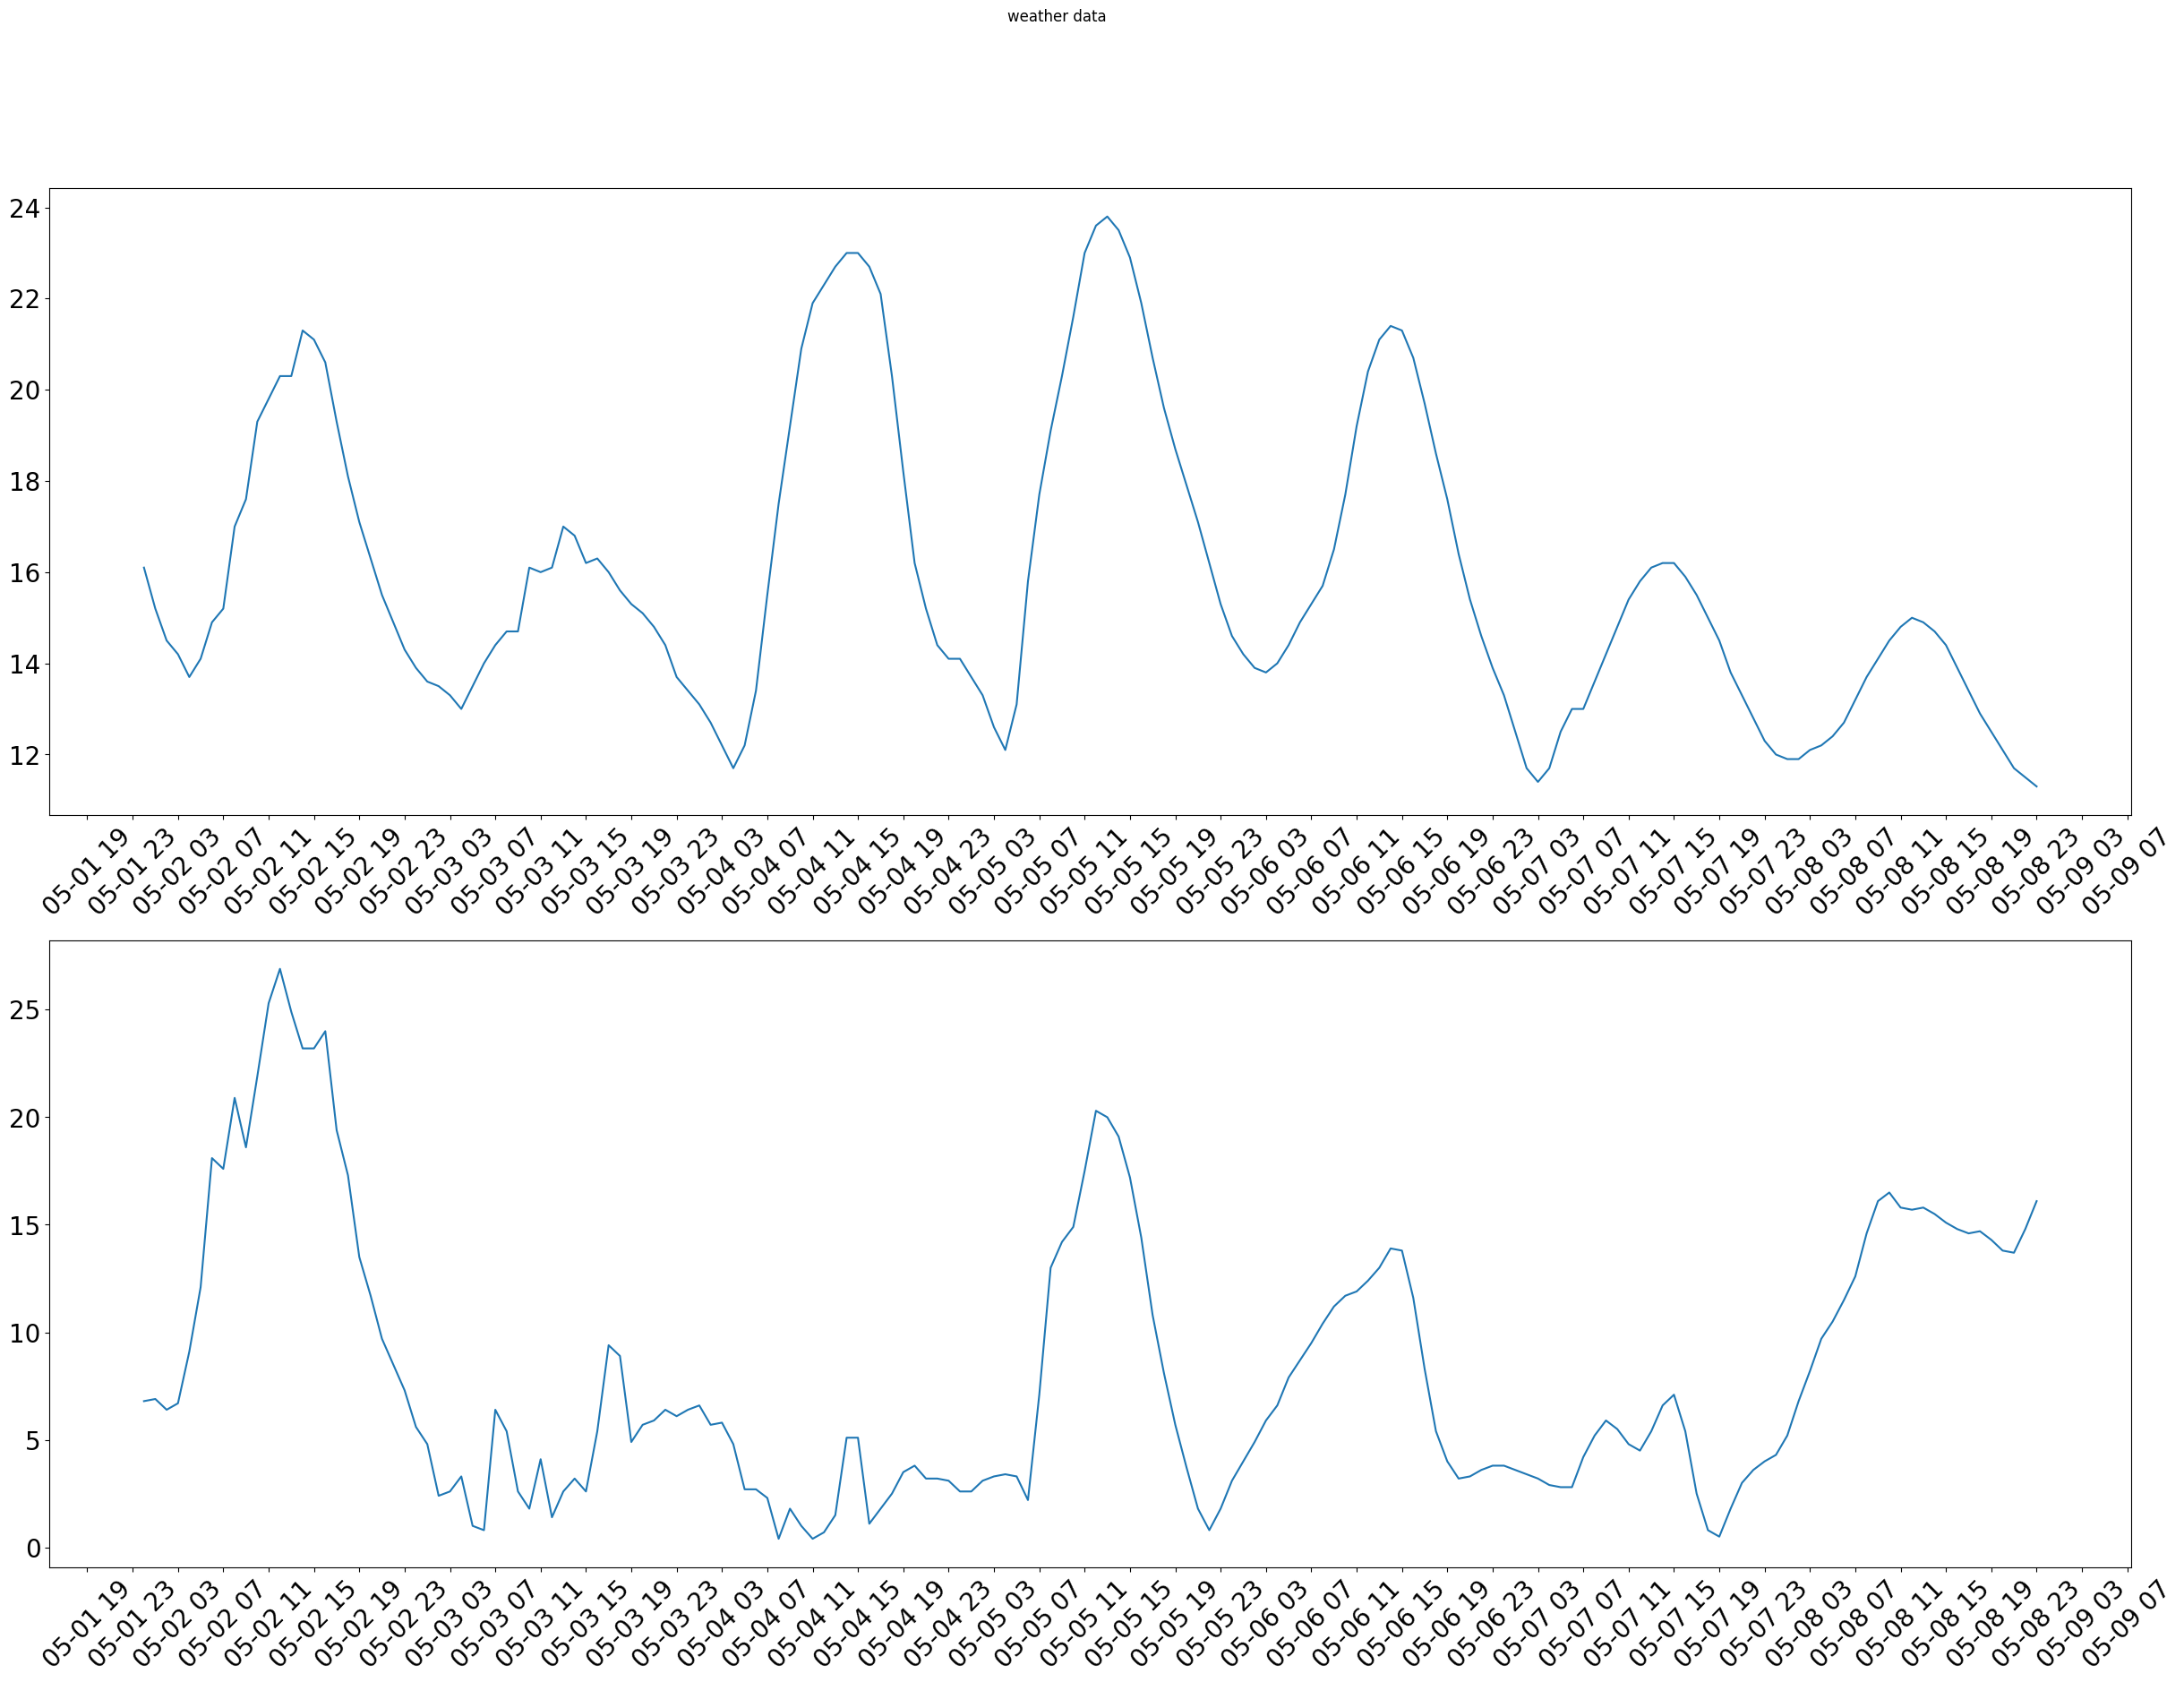

In [33]:
class FetchWeatherData(Tractor):
    i_longitude: In[float] = TIn()
    i_latitude: In[float] = TIn()
    r_weather_fc_client: Res[WeatherForecast] = TRes[WeatherForecast]()

    t_get_weather_data: GenerateWeatherGraphData = GenerateWeatherGraphData(
        uid='get-weather-data', i_longitude=i_longitude, i_latitude=i_latitude,
        r_weather_fc_client=r_weather_fc_client
    )


class PlotWeatherData(FetchWeatherData):
    t_plot_data: PlotGraphData = PlotGraphData(
        uid='plot-data',
        i_x_axis=FetchWeatherData.t_get_weather_data.o_x_axis,
        i_y_series=FetchWeatherData.t_get_weather_data.o_y_series,
    )

wfc = WeatherForecast()
pwd = PlotWeatherData(uid='brno-weather-data',
                        i_longitude=In[float](data=16.606836),
                        i_latitude=In[float](data=49.195061),
                        r_weather_fc_client=Res[WeatherForecast](r=wfc))

pwd.run()
print('')


Running tractors locally
========================


In [34]:
import random
import os

from Crypto.PublicKey import RSA
from Crypto.Util import number

from pytraction.base import Base, In, Out, Res, Traction, TList, OnUpdateCallable, Arg
from pytraction.tractor import Tractor

from pytraction.runner import SimpleRunner


class GenerateLargePrimeNumber(Traction):
    d_: str = "Generates list of large random numbers"
    o_primes: Out[TList[int]]
    a_bits: Arg[int] = Arg[int](a=1024)
    a_count: Arg[int]
    
    def _is_prime(self, n, k=5):
        """Miller-Rabin primality test."""
        if n <= 1:
            return False
        if n <= 3:
            return True
        if n % 2 == 0:
            return False
    
        # Write n as 2^r * d + 1
        r = 0
        d = n - 1
        while d % 2 == 0:
            d //= 2
            r += 1
    
        # Witness loop
        for _ in range(k):
            a = random.randint(2, n - 2)
            x = pow(a, d, n)
            if x == 1 or x == n - 1:
                continue
            for _ in range(r - 1):
                x = pow(x, 2, n)
                if x == n - 1:
                    break
            else:
                return False
        return True
    
    def _run(self, on_update: OnUpdateCallable = None):
        print(f"Generating {self.a_count.a} prime numbers")
        for x in range(self.a_count.a):
            while True:
                # Generate a random number of specified bit length
                prime_candidate = random.getrandbits(self.a_bits.a)
        
                # Ensure it's odd and has the correct number of bits
                prime_candidate |= (1 << self.a_bits.a - 1) | 1
        
                if self._is_prime(prime_candidate):
                    print(f"Generated prime ({x+1}/{self.a_count.a}): {prime_candidate}")
                    self.o_primes.data.append(prime_candidate)
                    break


from Crypto.PublicKey import RSA
from Crypto.Util import number

class GenerateRSA(Traction):
    i_primes: In[TList[int]]
    o_private_key: Out[str]
    o_public_key: Out[str]

    def _run(self, on_update: OnUpdateCallable = None):
        # No idea how to generat RSA keys
        # TODO
        print("Prime numbers to work with:")
        for x in self.i_primes.data:
            print(x)
        print("TODO: find out how to generate RSA private/public keys")
        self.o_private_key.data = "Private key: FIX"
        self.o_public_key.data = "Public key: FIX"


class RSATractor(Tractor):
    a_bits: Arg[int] = Arg[int](a=1024)
    a_count: Arg[int] = Arg[int](a=10)

    t_generate_numbers: GenerateLargePrimeNumber = GenerateLargePrimeNumber(uid='gen-numbers', a_bits=a_bits, a_count=a_count)
    t_generate_rsa: GenerateRSA = GenerateRSA(uid='rsa-gen', i_primes=t_generate_numbers.o_primes)

    o_private_key: Out[str] = t_generate_rsa.o_private_key
    o_public_key: Out[str] = t_generate_rsa.o_public_key

rsa_t = RSATractor(uid='rsa-tractor-1')
sr = SimpleRunner(rsa_t, 'rsa-gen-out-1')
#rsa_t.run()
sr.run()
print("Output files:")
for x in os.listdir('rsa-gen-out-1'):
    print(x)
    

FileNotFoundError: [Errno 2] No such file or directory: 'rsa-gen-out-1/-root-.json'

Simple runner will dump all tractions in running tractor to output directory. All files there have following name scheme: `<parent>:<traction.uid>.json`. In the case traction is STMD part of uid is also position of inputs in inputs list. There's special file called `-root-.json` which represents whole traction dumped before it was executed. This file can be later used to load tractor to SimpleRunner and resubmit execution from some traction

In [35]:
import json
print(json.dumps(json.load(open('rsa-gen-out-1/rsa-tractor-1::gen-numbers.json'))))

FileNotFoundError: [Errno 2] No such file or directory: 'rsa-gen-out-1/rsa-tractor-1::gen-numbers.json'

In [36]:
traction = Traction.from_json(json.load(open(os.path.join(args.monitor, '-root-.json'))))
runner = SimpleRunner(traction, 'rsa-gen-out-1')
runner.resubmit('t_generate_rsa')

NameError: name 'args' is not defined

Making your tractions visible for traction catalog
==================================================
There's traction discovery system based on python entry points. To add your tractions to entry points you can use:

In [1]:
import pytraction.transformations
from pytraction.pkgutils import traction_entry_points
list(traction_entry_points(pytraction.transformations))

['CartesianProduct = pytraction.transformations:CartesianProduct',
 'Explode = pytraction.transformations:Explode',
 'Extractor = pytraction.transformations:Extractor',
 'FilterDuplicates = pytraction.transformations:FilterDuplicates',
 'Flatten = pytraction.transformations:Flatten',
 'Repeat = pytraction.transformations:Repeat',
 'Repeat2D = pytraction.transformations:Repeat2D']

You put following to your setup.py:
```
    entry_points={
        "tractions": [
            x for x in traction_entry_points(quay_tractions.tractors.t_push_docker)
        ],
    },
```
Pytraction catalog will then list all python ep distributions with group == tractions